In [5]:
from tamkin import *
from molmod import *
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../code/')
from tamkin_multi_fidelity import *

In [6]:
# NpT is used when nothing else is specified (1bar)

sys.path.insert(0,'C:\\Anaconda3\\envs\\tamkintools\\lib\\site-packages\\tamkintools')

from tamkintools.optimized_rotor import *
from tamkintools.combine_scans import *


dimer   = load_molecule_g03fchk("scan_data/ethanoldimer/dim-p-p.fchk")
monomer = load_molecule_g03fchk("scan_data/ethanolmonomer/mon_p.fchk")
monomer_scan = load_rotscan_g03log("scan_data/ethanolmonomer/mon_p1.log")
#monomer_scan = load_rotscan_g03log("mon-np-scan.log")
dimer_scan = load_rotscan_g03log("scan_data/ethanoldimer/dim1-p-p-scan.log", top_indexes= [8])
#dimer_scan = load_rotscan_g03log("dim2-p-p-scan.log")
original_angle, original_energy = monomer_scan.potential
nma1    = NMA(monomer, ConstrainExt())

nma_angle = dihed_angle(nma1.coordinates[monomer_scan.dihedral])[0]/np.pi*180
print('nma angle is: ' +str(nma_angle))

nma2    = NMA(dimer, ConstrainExt())
rotor1  = Opt_Rotor(monomer_scan, monomer, rotsym=1, even=True,  num_levels = 100, dofmax=7)
rotor2  = Opt_Rotor(dimer_scan, dimer, rotsym=1, even=True, num_levels = 100, dofmax=7)
pf1rrho = PartFun(nma1, [ExtTrans(), ExtRot(symmetry_number=1)])
#pf1     = PartFun(nma1, [ExtTrans(), ExtRot(symmetry_number=1), rotor1])
pf2rrho = PartFun(nma2, [ExtTrans(), ExtRot(symmetry_number=1)])
#pf2     = PartFun(nma2, [ExtTrans(), ExtRot(symmetry_number=1), rotor2])
#ta1     = ThermoAnalysis(pf1,     [100, 200, 273.15, 298.15, 310, 400, 500, 1000])
#ta2     = ThermoAnalysis(pf2,     [3, 10, 30, 100, 200, 273.15, 298.15, 310, 400, 500, 1000])
#ta2     = ThermoAnalysis(pf2,     [3, 10, 30, 100, 300, 310, 3000])
ta1rrho = ThermoAnalysis(pf1rrho, [100, 200, 273.15, 298.15, 310, 400, 500, 1000])
ta2rrho = ThermoAnalysis(pf2rrho, [100, 200, 273.15, 298.15, 310, 400, 500, 1000])
#ta1.write_to_file("Monomerthermodynamics.csv")
#ta2.write_to_file("Dimerthermodynamics.csv")
#ta1rrho.write_to_file("Monomerthermodynamics_rrho.csv")
#ta2rrho.write_to_file("Dimerthermodynamics_rrho.csv")
#pf1.write_to_file("MonomerPartFun.csv")
#pf2.write_to_file("DimerPartFun.csv")
#rotor1.plot_levels_all("MonomerRotorLevels.png",300)
#rotor2.plot_levels("DimerRotorLevels.png",300)

nma angle is: 180.0


## Two Low Energy Datapoints

This notebook leads to a strategy how to select initial high fidelity sample points

Two data points at the same energy level are not enough for meaningful training, as the relationship between low and high fidelity data cannot be fixed.

An additional data point at a different energy level is necessary for a quantitative description (I think thats actually expected). This also leads to our strategy for selecting the high fidelity points to simulate based on a low fidelity scan:

- global minimum
- global maximum
- local minima (or something else depending on our goal)



# Monomer

minimum energy is : -407225.78781769215


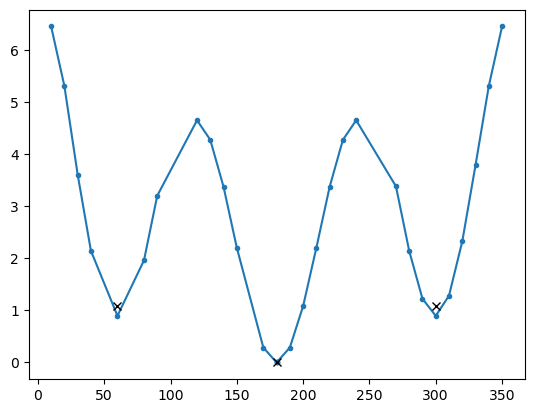

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1.]
angle range: 340.0001022524656
set angle range 360.0


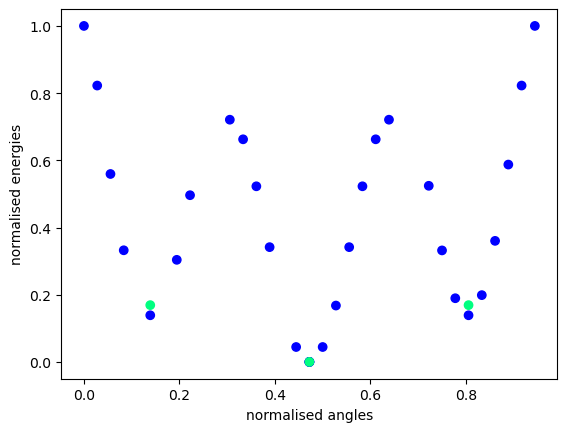

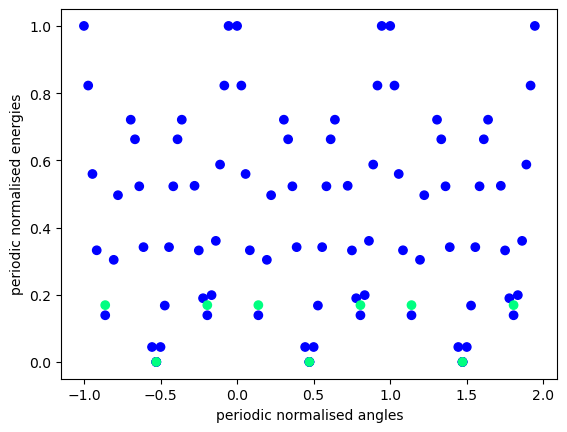

reconstraining parameters gp


(99, 2)
(99, 1)
Optimization restart 1/5, f = -227.26346215286617
Optimization restart 2/5, f = -227.26167341393625
Optimization restart 3/5, f = -227.2634217866197
Optimization restart 4/5, f = -227.26346215489787
Optimization restart 5/5, f = -227.26340659588772


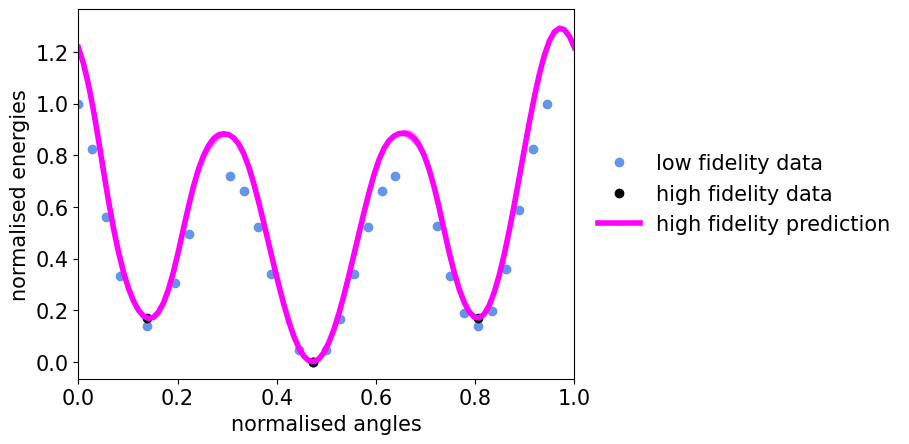

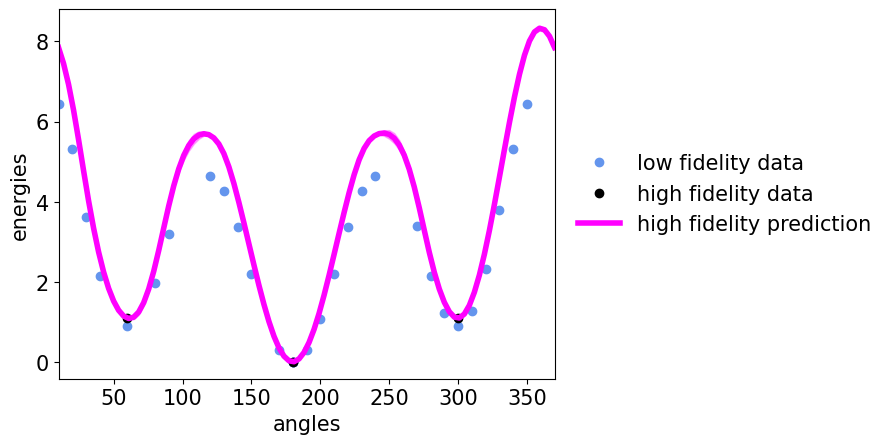

gp.,value,constraints,priors
multifidelity.Mat52.variance,0.8741265933892974,+ve,
multifidelity.Mat52.lengthscale,0.23593992104571007,+ve,
multifidelity.Mat52_1.variance,2.8035730334877876e-17,+ve,
multifidelity.Mat52_1.lengthscale,1.6693869465382782,+ve,
multifidelity.scale,1.2173601739454873,+ve,
mixed_noise.Gaussian_noise.variance,1e-07,fixed +ve,
mixed_noise.Gaussian_noise_1.variance,1e-07,fixed +ve,


In [7]:
cc_dihedral_monomer = np.array( [60,180,300] )
cc_energy_monomer   = np.array( [1.09, 0., 1.09] )

dihedral_monomer = ( rotor1.rot_scan.potential[0] )/np.pi*180
#print('dihedral monomer is: ' +str(dihedral_monomer))
pp = np.where(dihedral_monomer<0)
dihedral_monomer[pp] = dihedral_monomer[pp] + 360

p = np.argsort( dihedral_monomer )
#print('dihedral monomer[p] is ' +str(dihedral_monomer[p]))

energy_monomer = rotor1.rot_scan.potential[1]*2625.5002
# np.min(energy_monomer)
min_energy= energy_monomer[dihedral_monomer==180][0]
print('minimum energy is : ' +str(min_energy))
energy_monomer = energy_monomer - min_energy


dihedral_monomer = dihedral_monomer[p]

energy_monomer   = energy_monomer[p]
#print('CC-monomer_angle is:' + str(c_dihedral_monomer))
#print('CC-monomer_energy is:' + str(cc_energy_monomer))

plt.plot( dihedral_monomer , energy_monomer , ".-" )
plt.plot( cc_dihedral_monomer , cc_energy_monomer , "kx" )
plt.show()
plt.close()

aa = np.concatenate( [dihedral_monomer, cc_dihedral_monomer] )
bb = np.concatenate( [energy_monomer, cc_energy_monomer] )
weiwei = np.concatenate( [ 0.1*np.ones(len(dihedral_monomer)), np.ones(len(cc_dihedral_monomer)) ] )

# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( aa, bb, weiwei, angle_range=360.0)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern52)

# only positive phi vals
tmf.lin_mf_model.gpy_model.constrain_positive()
# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0000001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0000001)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("normalised_multi_fidelity_red_fail_0")
tmf.plot_results("multi_fidelity_red_fail_0")

tmf.lin_mf_model.gpy_model

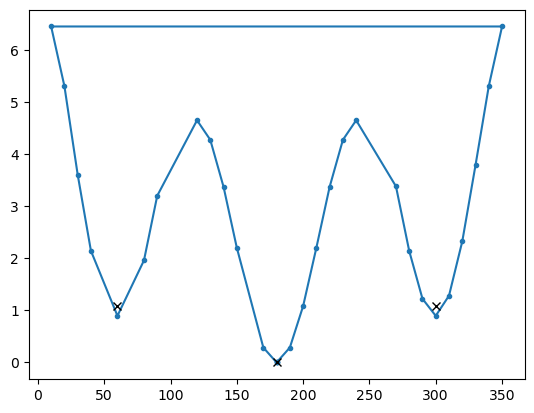

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1.]
angle range: 340.0001022524656
set angle range 360.0


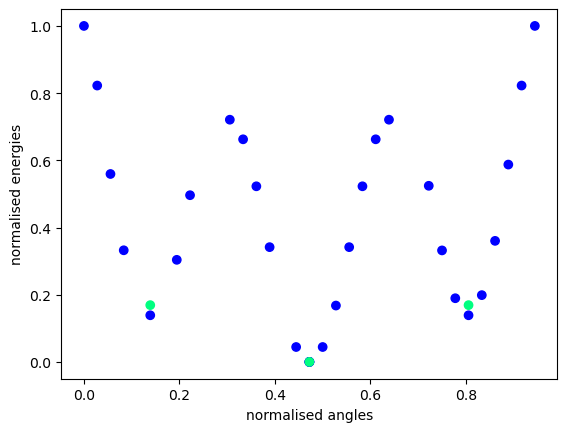

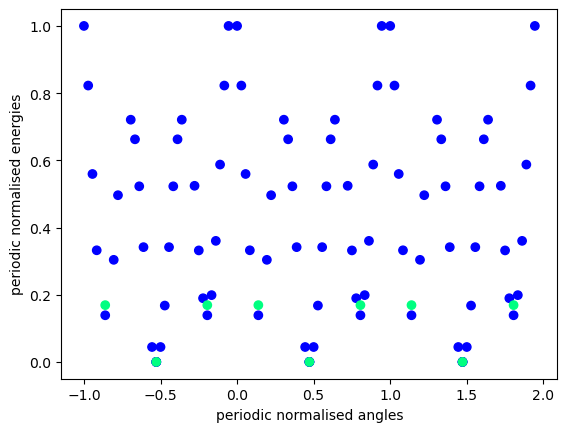

(99, 2)
(99, 1)
Optimization restart 1/5, f = -227.26344517873386
Optimization restart 2/5, f = -227.26346216306234
Optimization restart 3/5, f = -227.26346215469138
Optimization restart 4/5, f = -227.26346216801056
Optimization restart 5/5, f = -227.2634599016169


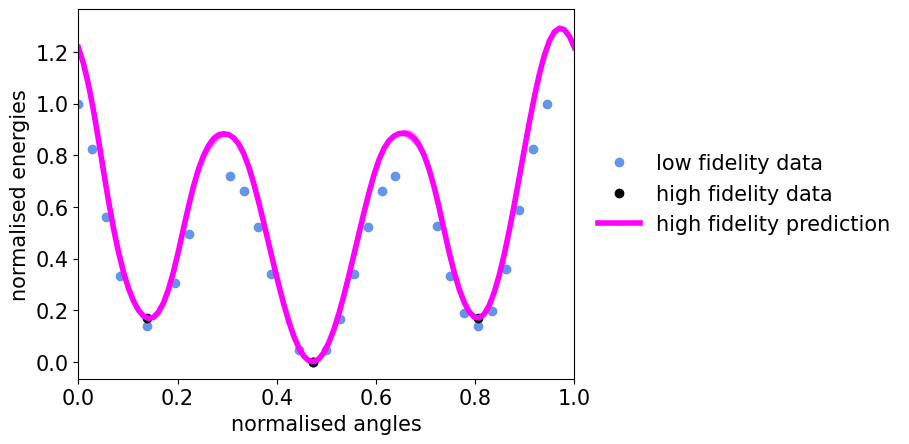

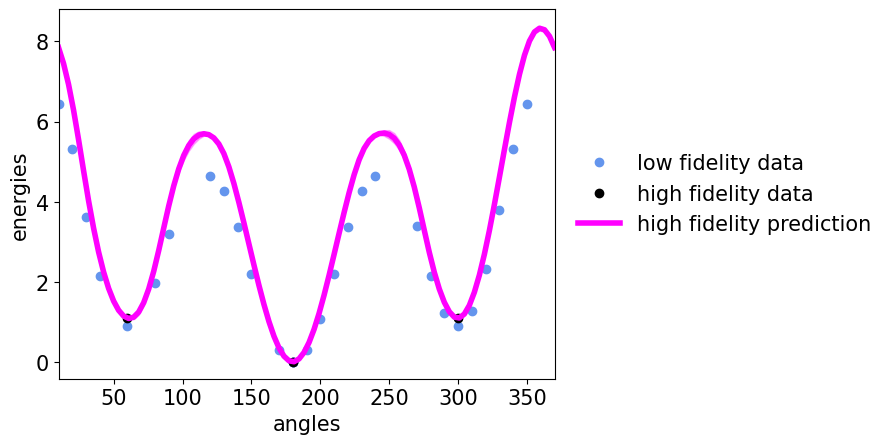

gp.,value,constraints,priors
multifidelity.Mat52.variance,0.8741266830145995,+ve,
multifidelity.Mat52.lengthscale,0.23593992573261993,+ve,
multifidelity.Mat52_1.variance,4.227008129233374e-66,+ve,
multifidelity.Mat52_1.lengthscale,249.18782420300167,+ve,
multifidelity.scale,1.2173601740222153,,
mixed_noise.Gaussian_noise.variance,1e-07,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-07,+ve fixed,


In [8]:
cc_dihedral_monomer = np.array( [60,180,300] )
cc_energy_monomer = np.array( [ 1.09,0., 1.09] )


dihedral_monomer = ( rotor1.rot_scan.potential[0] )/np.pi*180
pp = np.where(dihedral_monomer<0)
dihedral_monomer[pp] = dihedral_monomer[pp] + 360

p = np.argsort( dihedral_monomer )

energy_monomer = rotor1.rot_scan.potential[1]*2625.5002
energy_monomer -= energy_monomer[dihedral_monomer==180][0]# np.min(energy_monomer)

#dihedral_monomer = dihedral_monomer[p]

#energy_monomer   = energy_monomer[p]

plt.plot( dihedral_monomer , energy_monomer , ".-" )
plt.plot( cc_dihedral_monomer , cc_energy_monomer , "kx" )
plt.show()
plt.close()

aa = np.concatenate( [dihedral_monomer, cc_dihedral_monomer] )
bb = np.concatenate( [energy_monomer, cc_energy_monomer] )
weiwei = np.concatenate( [ 0.1*np.ones(len(dihedral_monomer)), np.ones(len(cc_dihedral_monomer)) ] )

# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( aa, bb, weiwei, angle_range=360.0)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern52)

# only positive phi vals
#tmf.lin_mf_model.gpy_model.constrain_positive()
# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0000001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0000001)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("normalised_multi_fidelity_red_fail_1")
tmf.plot_results("multi_fidelity_red_fail_1")

tmf.lin_mf_model.gpy_model


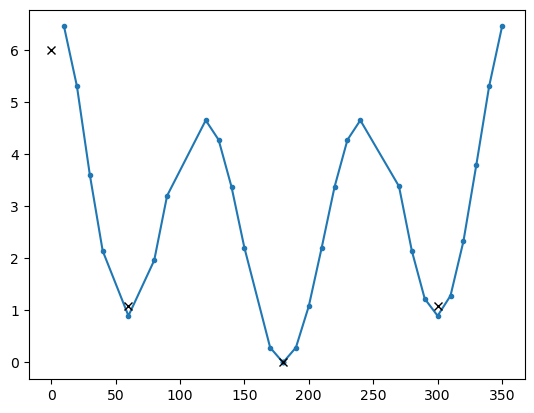

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
angle range: 350.00013359140917
set angle range 360.0


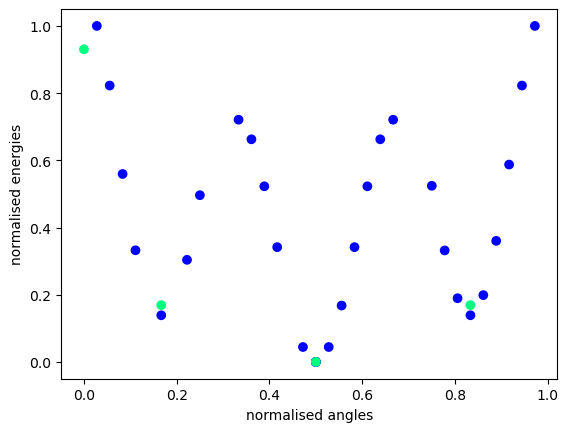

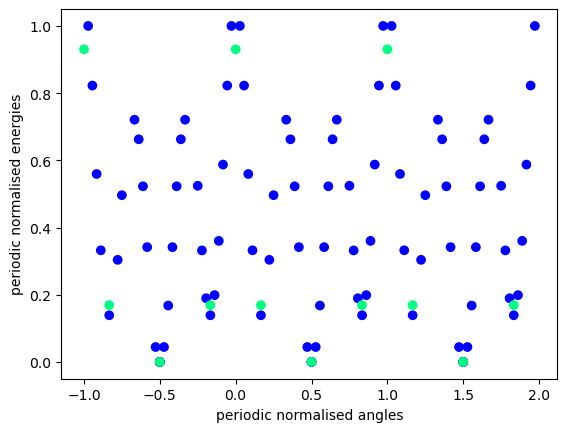

(102, 2)
(102, 1)
Optimization restart 1/5, f = -190.70243091534383
Optimization restart 2/5, f = -190.29514054955325
Optimization restart 3/5, f = -190.70243096045706
Optimization restart 4/5, f = -190.70243092381918
Optimization restart 5/5, f = -190.70243098150604


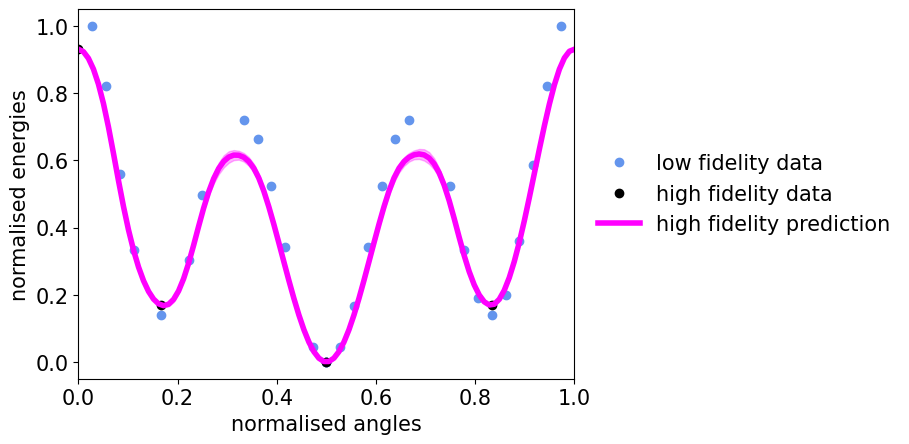

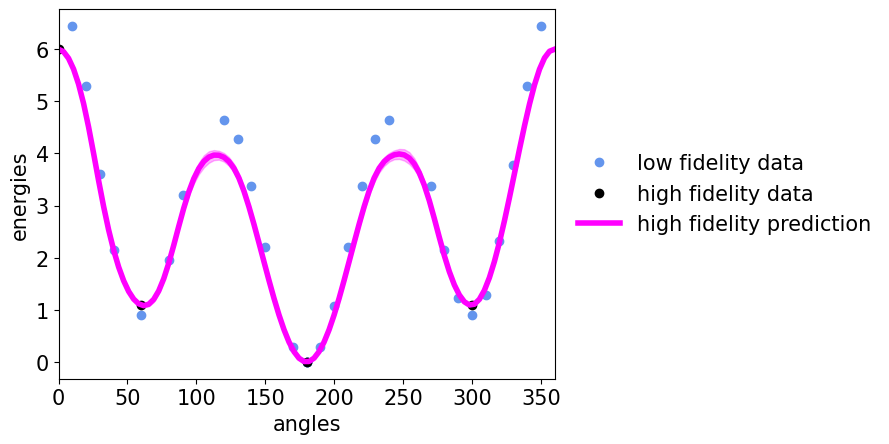

gp.,value,constraints,priors
multifidelity.Mat52.variance,0.8774777530767481,+ve,
multifidelity.Mat52.lengthscale,0.23676733619997606,+ve,
multifidelity.Mat52_1.variance,0.002185253064425638,+ve,
multifidelity.Mat52_1.lengthscale,0.3256255686344605,+ve,
multifidelity.scale,0.8145581920438186,,
mixed_noise.Gaussian_noise.variance,1e-07,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-07,+ve fixed,


In [145]:
cc_dihedral_monomer = np.array( [0.,60,180,300] )
cc_energy_monomer = np.array( [ 6, 1.09,0., 1.09] )


#dihedral_monomer = ( rotor1.rot_scan.potential[0] )/np.pi*180
pp = np.where(dihedral_monomer<0)
dihedral_monomer[pp] = dihedral_monomer[pp] + 360

p = np.argsort( dihedral_monomer )

energy_monomer = rotor1.rot_scan.potential[1]*2625.5002
energy_monomer -= energy_monomer[dihedral_monomer==180][0] # np.min(energy_monomer)

dihedral_monomer = dihedral_monomer[p]

energy_monomer   = energy_monomer[p]

plt.plot( dihedral_monomer , energy_monomer , ".-" )
plt.plot( cc_dihedral_monomer , cc_energy_monomer , "kx" )
plt.show()
plt.close()

aa = np.concatenate( [dihedral_monomer, cc_dihedral_monomer] )
bb = np.concatenate( [energy_monomer, cc_energy_monomer] )
weiwei = np.concatenate( [ 0.1*np.ones(len(dihedral_monomer)), np.ones(len(cc_dihedral_monomer)) ] )

# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( aa, bb, weiwei, angle_range=360.0)
# initialize multi fidelity modela
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern52)

# only positive phi vals
#tmf.lin_mf_model.gpy_model.constrain_positive()
# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0000001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0000001)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("normalised_multi_fidelity_red")
tmf.plot_results("multi_fidelity_red")

tmf.lin_mf_model.gpy_model

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1.]
angle range: 340.0001022524656
set angle range 360.0


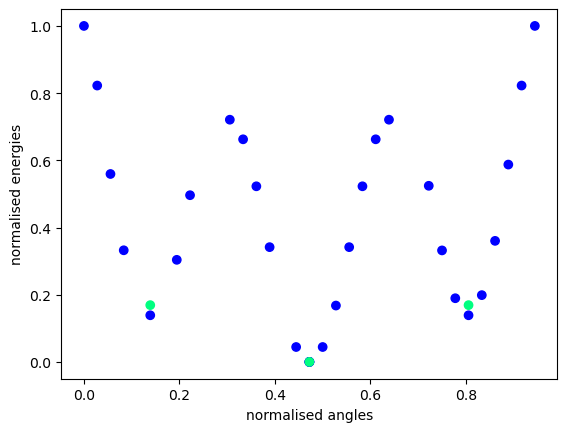

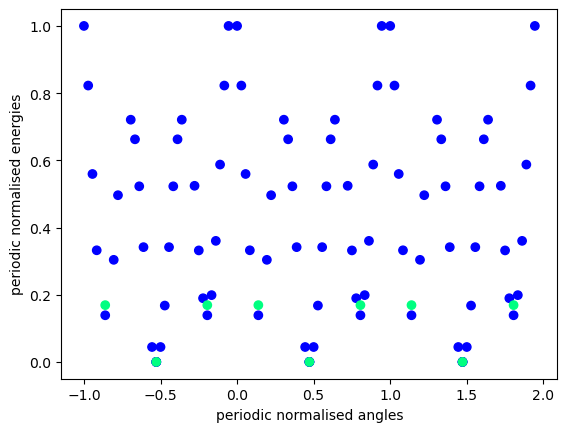

data_tmf is: <function tamkin_multi_fidelity.predict at 0x0000022C9D1C8820>


In [13]:
'checking the Thermo data and the zero point energy with Tamkintools'
import sys
sys.path.insert(0,'C:\\Anaconda3\\envs\\tamkintools\\lib\\site-packages\\tamkintools')

from tamkintools.optimized_rotor import *
from tamkintools.combine_scans import *
sys.path.insert(0, '../code/')
from tamkin_multi_fidelity import *
'we take the data from tmf code to get the result of MuFi data and then git it with tamkin'
tmf = tamkin_multi_fidelity( aa, bb, weiwei, angle_range=360.0)
data_tmf = tamkin_multi_fidelity.predict
print('data_tmf is: ' +str(data_tmf))




## Adding a High Endergy Datapoint


...leads to meaningful results and confirms the strategy, as the uncertainty in unexplored maxima is high.

# Dimer

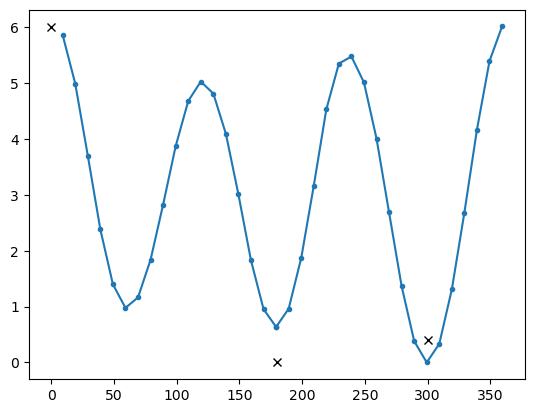

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
angle range: 359.2058796231005
set angle range 360.0


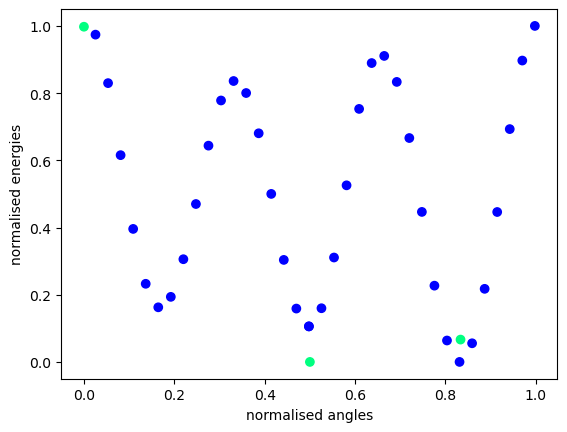

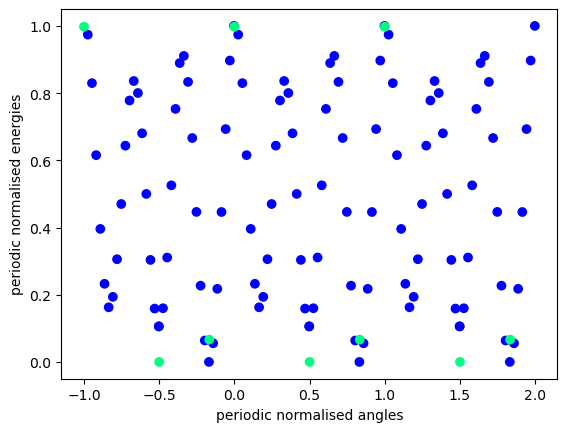

(120, 2)
(120, 1)
Optimization restart 1/5, f = -178.06650773819564
Optimization restart 2/5, f = -178.0665077620172
Optimization restart 3/5, f = -178.06650772258777
Optimization restart 4/5, f = -178.0665077640248
Optimization restart 5/5, f = -178.06650776368477


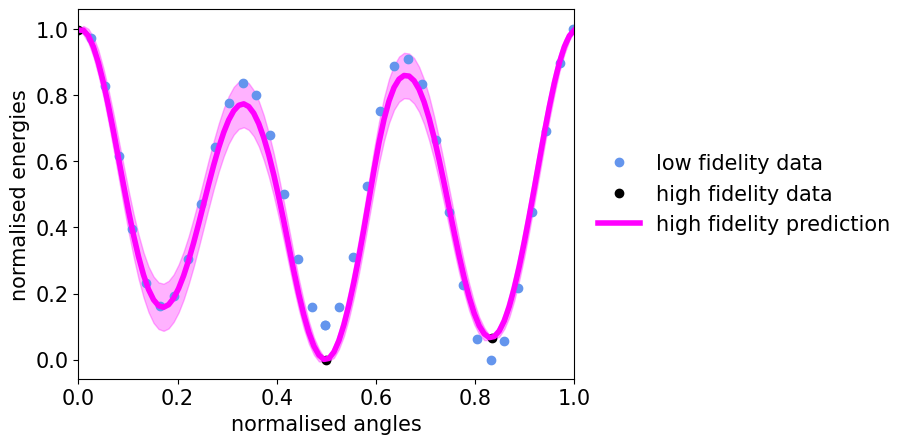

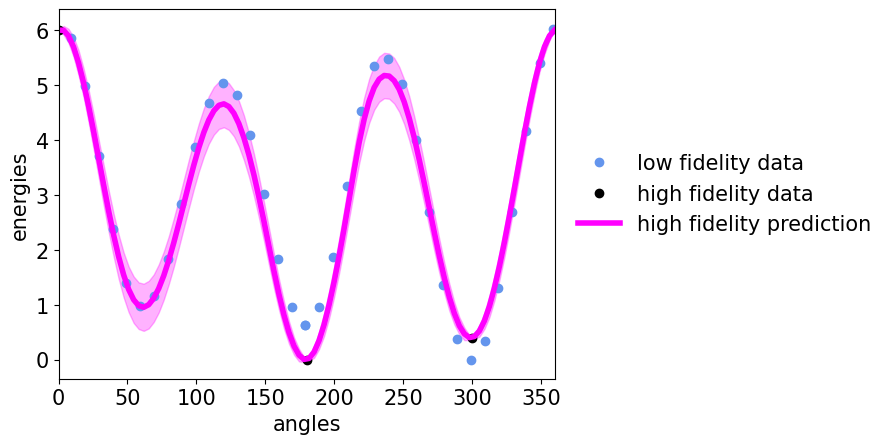

gp.,value,constraints,priors
multifidelity.Mat32.variance,1.0787677213034126,+ve,
multifidelity.Mat32.lengthscale,0.40381642917771793,+ve,
multifidelity.Mat32_1.variance,0.0053709011030129445,+ve,
multifidelity.Mat32_1.lengthscale,0.10813842703602254,+ve,
multifidelity.scale,0.9556533875041295,,
mixed_noise.Gaussian_noise.variance,1e-07,+ve fixed,
mixed_noise.Gaussian_noise_1.variance,1e-07,+ve fixed,


In [24]:
cc_dihedral_dimer = np.array( [0,180,300] )
cc_energy_dimer = np.array( [6,0, 0.4] )

dihedral_dimer = ( rotor2.rot_scan.potential[0] )/np.pi*180
pp = np.where(dihedral_dimer<0)
dihedral_dimer[pp] = dihedral_dimer[pp] + 360

p = np.argsort( dihedral_dimer )

energy_dimer = rotor2.rot_scan.potential[1]*2625.5002
energy_dimer -= np.min(energy_dimer)

dihedral_dimer = dihedral_dimer[p]

energy_dimer   = energy_dimer[p]

plt.plot( dihedral_dimer , energy_dimer , ".-" )
plt.plot( cc_dihedral_dimer , cc_energy_dimer , "kx" )
plt.show()
plt.close()

aa = np.concatenate( [dihedral_dimer, cc_dihedral_dimer] )
bb = np.concatenate( [energy_dimer, cc_energy_dimer] )
weiwei = np.concatenate( [ 0.1*np.ones(len(dihedral_dimer)), np.ones(len(cc_dihedral_dimer)) ] )

# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( aa, bb, weiwei,  angle_range=360.0)
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern32)

# adjust hyperparameters and so on before model is trained
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.0000001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0000001)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("dimer_normalised_multi_fidelity_red")
tmf.plot_results("dimer_multi_fidelity_red")

tmf.lin_mf_model.gpy_model